In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from itertools import cycle
import math

# Assign numpy.interp to interp for backward compatibility, or use np.interp directly
interp = np.interp

In [5]:
Data_Path = "WineQT.csv"   #WineQT.csv

df = pd.read_csv(Data_Path)
print("Data loaded. Shape:", df.shape)
display(df.head())

# Quick info
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())


Data loaded. Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4



Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Id']

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


In [6]:

print("\nDescriptive statistics:")
display(df.describe())

# If the file has any extra index columns, drop them. Ensure the expected columns exist.
expected_cols = ['fixed acidity','volatile acidity','citric acid','residual sugar',
                 'chlorides','free sulfur dioxide','total sulfur dioxide','density',
                 'pH','sulphates','alcohol','quality']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"The dataset is missing expected columns: {missing}")


Descriptive statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


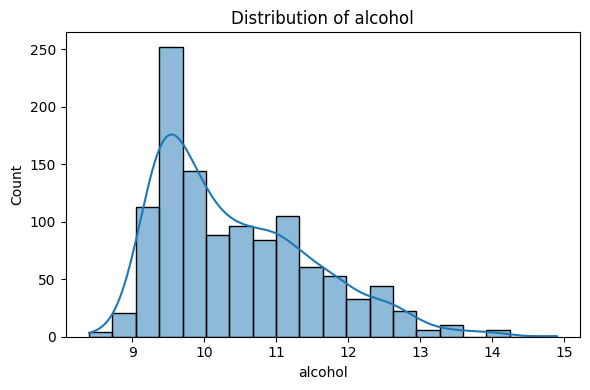

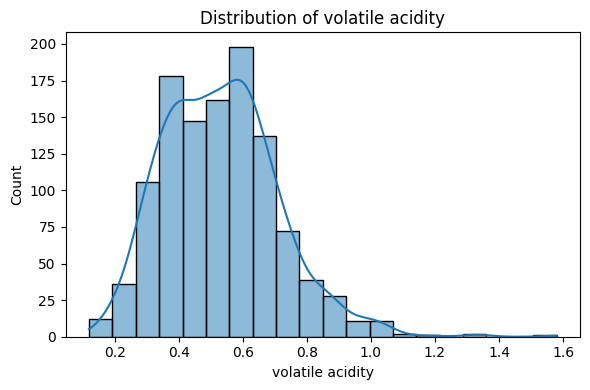

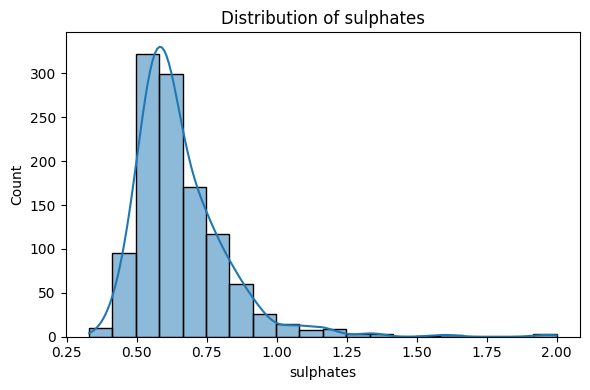

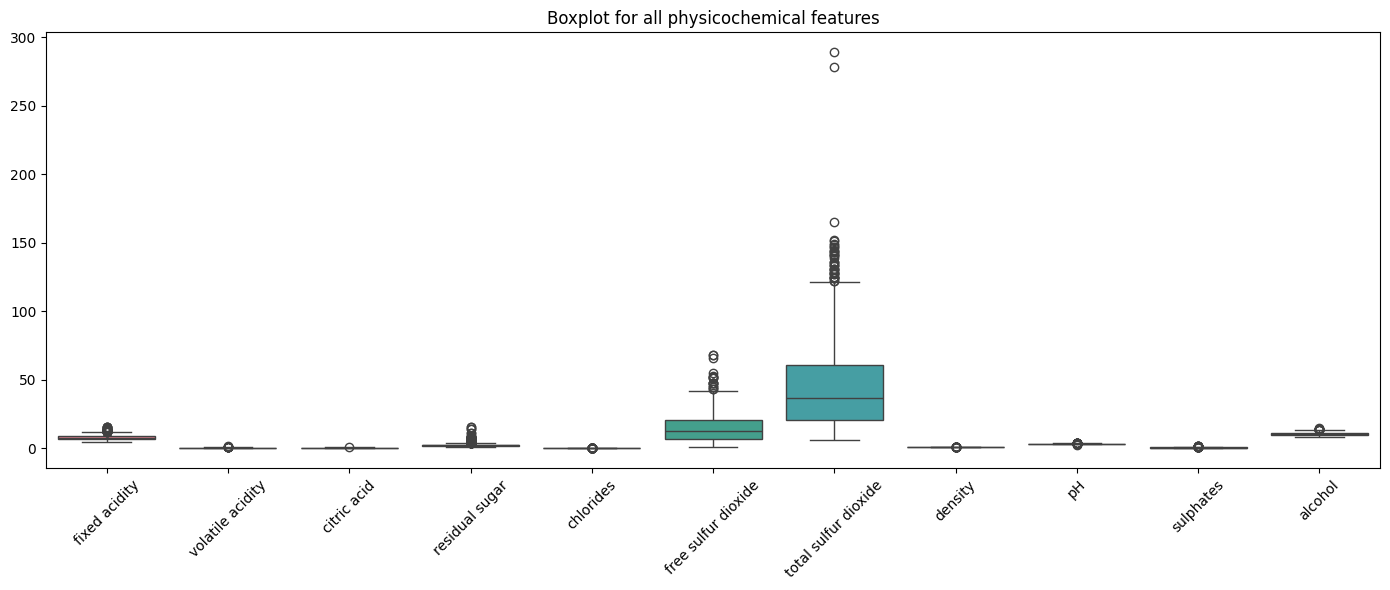

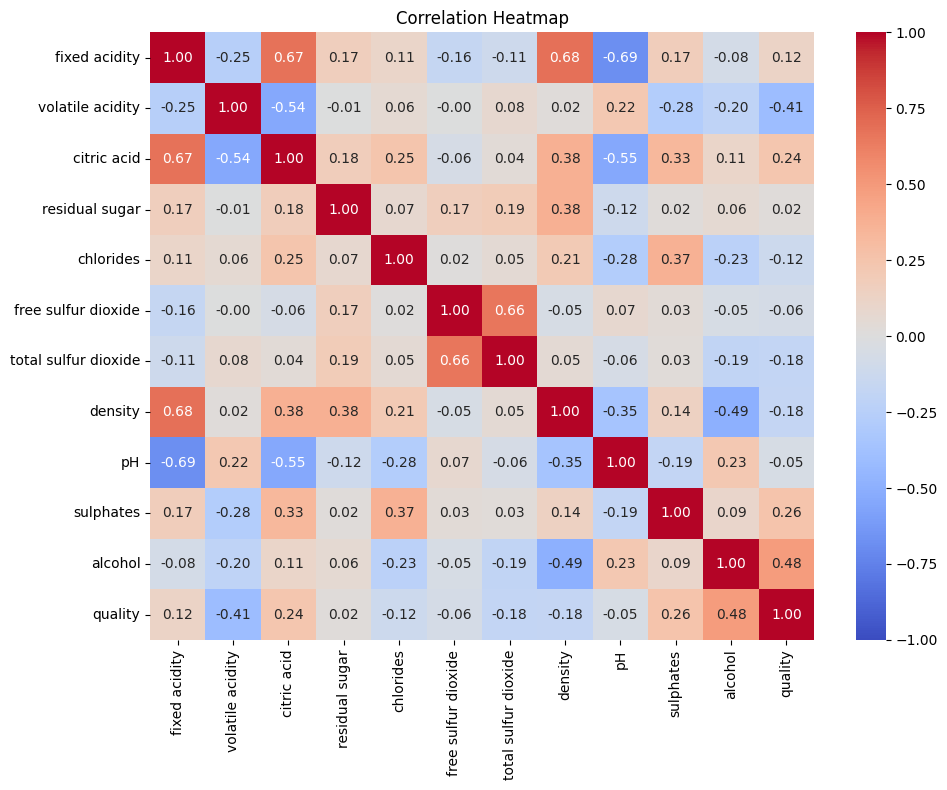

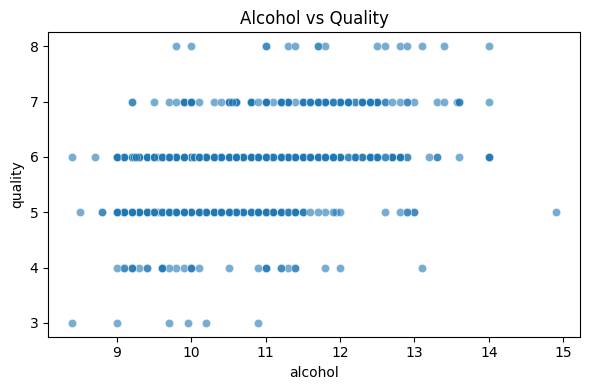

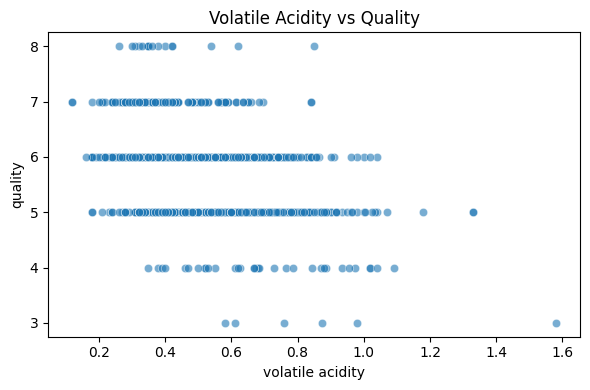


Correlation of features with quality:
 quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64


In [8]:
import os

# Create a directory to save plots
PLOTS_DIR = 'plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# EDA PLOTS


# 5.1 Histograms for selected features
features_hist = ['alcohol','volatile acidity','sulphates']
for feat in features_hist:
    plt.figure(figsize=(6,4))
    sns.histplot(df[feat], bins=20, kde=True)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.tight_layout()
    fpath = os.path.join(PLOTS_DIR, f"hist_{feat.replace(' ','_')}.png")
    plt.savefig(fpath, dpi=150)
    plt.show()

# 5.2 Boxplot (all features) to inspect outliers
plt.figure(figsize=(14,6))
sns.boxplot(data=df[expected_cols[:-1]])  # all input features
plt.xticks(rotation=45)
plt.title("Boxplot for all physicochemical features")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "boxplot_all_features.png"), dpi=150)
plt.show()

# 5.3 Correlation heatmap
plt.figure(figsize=(10,8))
corr = df[expected_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "correlation_heatmap.png"), dpi=150)
plt.show()

# 5.4 Scatterplots: alcohol vs quality, volatile acidity vs quality
plt.figure(figsize=(6,4))
sns.scatterplot(x='alcohol', y='quality', data=df, alpha=0.6)
plt.title("Alcohol vs Quality")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "scatter_alcohol_quality.png"), dpi=150)
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='volatile acidity', y='quality', data=df, alpha=0.6)
plt.title("Volatile Acidity vs Quality")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "scatter_volatile_quality.png"), dpi=150)
plt.show()

# Print correlation with quality for quick reference
corr_with_quality = corr['quality'].sort_values(ascending=False)
print("\nCorrelation of features with quality:\n", corr_with_quality)

In [10]:
#4. PREPROCESSING

RANDOM_STATE = 42 # Define RANDOM_STATE for reproducibility

# 6.1 Convert quality -> 3-class labels: 0 (low),1 (medium),2 (high)
def quality_to_class(q):
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2

df['quality_label'] = df['quality'].apply(quality_to_class)
print("\nClass distribution (quality_label):")
print(df['quality_label'].value_counts())

# 6.2 Features (X) and target (y)
X = df.drop(['quality','quality_label'], axis=1)
y = df['quality_label']

# 6.3 Optional: Handle imbalance (SMOTE) — set to True if you want to oversample
USE_SMOTE = False
if USE_SMOTE:
    sm = SMOTE(random_state=RANDOM_STATE)
    X, y = sm.fit_resample(X, y)
    print("After SMOTE class counts:", np.bincount(y))

# 6.4 Train-test split (stratified to keep class ratios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

print("\nTrain/Test sizes:", X_train.shape, X_test.shape)

# 6.5 Scaling features (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "scaler.joblib")


Class distribution (quality_label):
quality_label
0    522
1    462
2    159
Name: count, dtype: int64

Train/Test sizes: (914, 12) (229, 12)


['scaler.joblib']


Random Forest - Baseline Performance
Accuracy: 0.716
Precision (macro): 0.735
Recall (macro): 0.687
F1 (macro): 0.706

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       105
           1       0.65      0.71      0.68        92
           2       0.79      0.59      0.68        32

    accuracy                           0.72       229
   macro avg       0.73      0.69      0.71       229
weighted avg       0.72      0.72      0.72       229



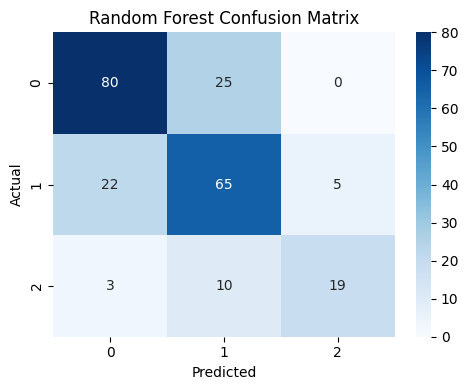

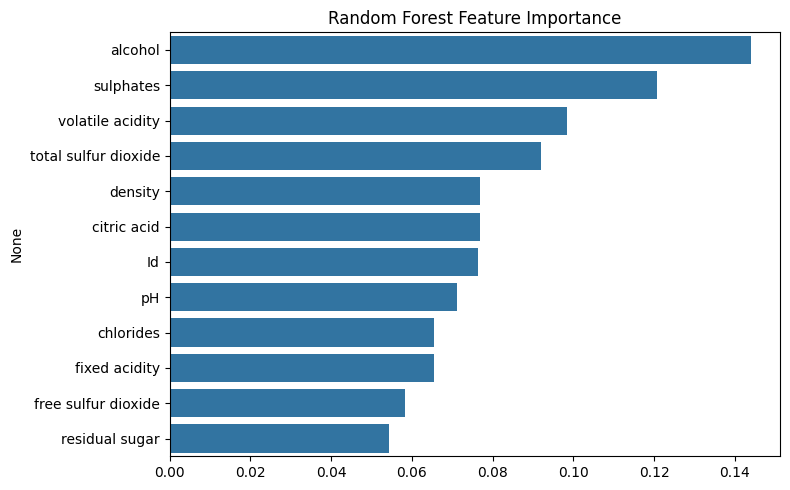

In [ ]:
# ---- 7. Baseline Model: Random Forest -----------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
print("\nRandom Forest - Baseline Performance")
print("Accuracy: {:.3f}".format(acc_rf))
print("Precision (macro): {:.3f}".format(prec_rf))
print("Recall (macro): {:.3f}".format(rec_rf))
print("F1 (macro): {:.3f}".format(f1_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "rf_confusion_matrix.png"), dpi=150)
plt.show()

# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "rf_feature_importance.png"), dpi=150)
plt.show()


XGBoost Accuracy: 0.668
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       105
           1       0.62      0.62      0.62        92
           2       0.64      0.56      0.60        32

    accuracy                           0.67       229
   macro avg       0.66      0.64      0.65       229
weighted avg       0.67      0.67      0.67       229


SVM Accuracy: 0.686
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       105
           1       0.62      0.67      0.65        92
           2       0.65      0.41      0.50        32

    accuracy                           0.69       229
   macro avg       0.67      0.62      0.64       229
weighted avg       0.68      0.69      0.68       229



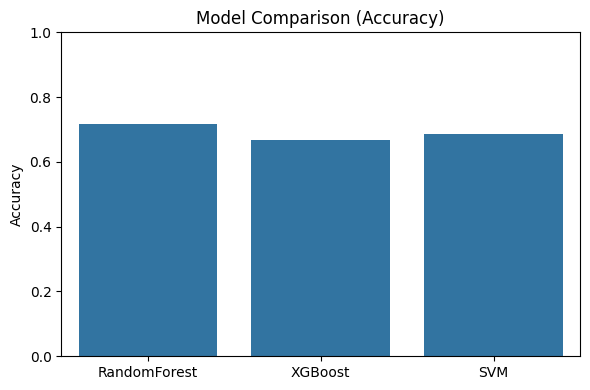

In [ ]:
# ---- 8. Comparison models: XGBoost and SVM -----------------------------------
# XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6,
                            use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy: {:.3f}".format(acc_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division=0))

# SVM (RBF)
svm_clf = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("\nSVM Accuracy: {:.3f}".format(acc_svm))
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Plot comparison bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=['RandomForest','XGBoost','SVM'], y=[acc_rf, acc_xgb, acc_svm])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Comparison (Accuracy)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "model_comparison_accuracy.png"), dpi=150)
plt.show()

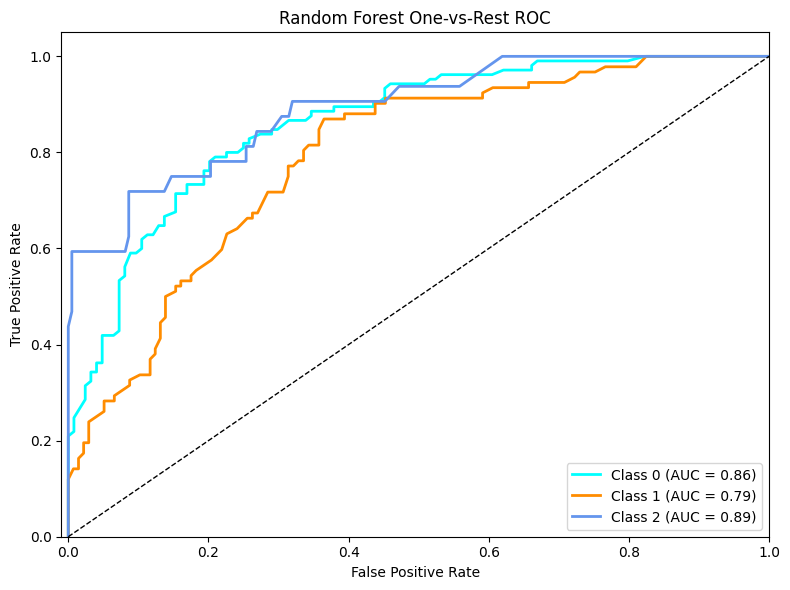

In [ ]:
# ---- 9. Multiclass ROC AUC (One-vs-Rest) plotting -----------------------------
# Binarize labels for ROC calculation
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Random Forest probabilities for ROC
y_score = y_proba_rf

# Compute ROC curve and ROC area for each class
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8,6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest One-vs-Rest ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "rf_roc_multiclass.png"), dpi=300,
    bbox_inches="tight")
plt.show()



Starting RandomizedSearchCV for Random Forest (this may take a while)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.6793850957785383

Tuned Random Forest - Test performance
Accuracy: 0.686
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       105
           1       0.61      0.66      0.64        92
           2       0.65      0.53      0.59        32

    accuracy                           0.69       229
   macro avg       0.68      0.65      0.66       229
weighted avg       0.69      0.69      0.69       229



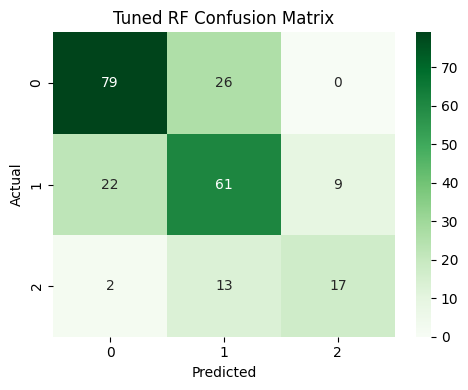

Saved best RF model to best_random_forest.joblib


In [14]:
# ---- 10. Hyperparameter Tuning (RandomizedSearchCV for RF) --------------------
from scipy.stats import randint as sp_randint

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 8, 12, 16],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

n_iter_search = 20
rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                               param_distributions=param_dist,
                               n_iter=n_iter_search, scoring='accuracy',
                               cv=5, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

print("\nStarting RandomizedSearchCV for Random Forest (this may take a while)...")
rf_random.fit(X_train_scaled, y_train)

print("\nBest parameters found:")
print(rf_random.best_params_)
print("Best CV score:", rf_random.best_score_)

best_rf = rf_random.best_estimator_
# Evaluate best RF on test set
y_pred_best = best_rf.predict(X_test_scaled)
print("\nTuned Random Forest - Test performance")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_best)))
print(classification_report(y_test, y_pred_best, zero_division=0))

# Confusion matrix for tuned RF
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Tuned RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "rf_tuned_confusion_matrix.png"), dpi=150)
plt.show()

# Save best model
joblib.dump(best_rf, "best_random_forest.joblib")
print("Saved best RF model to best_random_forest.joblib")

In [15]:
# ---- 11. Small GridSearchCV example (for documentation / screenshot) ----------
param_grid_small = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid_small, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)
print("\nGridSearch best params:", grid.best_params_, "best_score:", grid.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

GridSearch best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} best_score: 0.6826898188093184


In [16]:
# ---- 12. Save reports and basic summary to CSV --------------------------------
# Save classification reports
def save_classification_report_to_file(y_true, y_pred, filename):
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(filename)
    print("Saved classification report to", filename)

save_classification_report_to_file(y_test, y_pred_rf, os.path.join(PLOTS_DIR, "rf_classification_report.csv"))
save_classification_report_to_file(y_test, y_pred_best, os.path.join(PLOTS_DIR, "rf_tuned_classification_report.csv"))
save_classification_report_to_file(y_test, y_pred_xgb, os.path.join(PLOTS_DIR, "xgb_classification_report.csv"))
save_classification_report_to_file(y_test, y_pred_svm, os.path.join(PLOTS_DIR, "svm_classification_report.csv"))

Saved classification report to plots/rf_classification_report.csv
Saved classification report to plots/rf_tuned_classification_report.csv
Saved classification report to plots/xgb_classification_report.csv
Saved classification report to plots/svm_classification_report.csv
